In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import linear_model
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os
import sys

sys.path.append('../../Utils')
from metrics import compute_metrics

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../../Data/')

RNA_PROT_EMBED = data_dir+'ProcessedData/protein_embeddings/rna_protein_u64embeddings.pkl'

SEED = 0

#Cell lines
AT2 = ['AT2_04M_F0','AT2_04M_F10','AT2_18M_F0','AT2_18M_F10']
AM = ['AM_04M_F0','AM_04M_F10','AM_18M_F0','AM_18M_F10']
cell_lines = AT2+AM

In [2]:
with open(RNA_PROT_EMBED,'rb') as file:
    rna_prot_embed = pickle.load(file)

#With linear regression, need to work with log transformed data (log normal, mrna, protein, prot length)
for cell in cell_lines:
    rna_prot_embed[cell]['log2_mRNA_TMM'] = np.log2(1+rna_prot_embed[cell]['mRNA_TMM'])
    rna_prot_embed[cell]['log2_ProteinAUC'] = np.log2(1+rna_prot_embed[cell]['ProteinAUC'])
    rna_prot_embed[cell]['log2_ProteinLength'] = np.log2(1+rna_prot_embed[cell]['ProteinLength'])

### Testing procedure
* For each model tested, run on say 5 fold cross validation. Run with and without protein embedding.
* For each cv, save evaluation results, mse, smse, mae, r^2, pearson and spearman.
* Testing permutations include: (mRNA), (mRNA, protein length), (mRNA, protein length, protein embedding)

<img src="../../../smse.PNG" style="width: 500px;"/>

In [3]:
def x_foldcv(x_data,y_data,model,fc,x_folds=5,ran_state=0,shuf=True):
    '''
    -Function takes in data and computes x_fold cv using the specified model.
    -Returns the average test results from cross validation as a pandas series
    -calling fit multiple times on the same model should overwrite previous parameters, if model is more iterative there is
    usually an option of partial fit.
    
    x_data,y_data - dataframes, sliced from data probably
    x_data - dataframe of all features
    y_data - corresponding dataframe to x_data containing all the labels
    '''
    assert isinstance(x_data,pd.DataFrame) and isinstance(y_data,pd.DataFrame)
    assert isinstance(x_folds, int)
    
    kf = KFold(n_splits = x_folds, shuffle = shuf, random_state = ran_state)
    cv_results = pd.DataFrame()
    
    for train_index, test_index in kf.split(x_data):
        
        x_train = x_data.iloc[train_index,:]
        x_test = x_data.iloc[test_index,:]
        
        y_train = y_data.iloc[train_index,:].values
        y_test = y_data.iloc[test_index,:].values
        
        model.fit(x_train,y_train)
        predicted = model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train,fc_scale=fc), ignore_index=True)

    return cv_results.mean()

### For each cell line run 10 fold cross validation, computing metrics using evaluation function

In [4]:
tissue_metrics = pd.DataFrame()
# (mRNA), (mRNA, protein length), (mRNA, protein length, protein embedding)
feature_sets = {'mrna':[68], 'mrna_pl':[68,70], 'mrna_pl_embed':[68,70]+list(range(4,68))}

model = linear_model.LinearRegression()

for cell in cell_lines:
    for features in feature_sets:
        
        x_data = rna_prot_embed[cell].iloc[:,feature_sets[features]] #view of dataframe
        y_data = rna_prot_embed[cell].iloc[:,[69]] #view of dataframe

        mean_cv = x_foldcv(x_data,y_data,model,fc=2,x_folds=10)
        mean_cv.name = f'{cell}_{features}'
        tissue_metrics = tissue_metrics.append(mean_cv)
    
tissue_metrics.mean()

evs              3.054186e-01
mae              9.647745e-01
mean_abs_fc      1.956567e+00
median_abs_fc    1.720497e+00
mse              1.574476e+00
pearsonr         5.419564e-01
pearsonr_p       2.551795e-08
r2               3.035010e-01
smse             6.943174e-01
spearmanrho      5.242864e-01
spearmanrho_p    2.849813e-07
dtype: float64

In [5]:
tissue_metrics

,evs,mae,mean_abs_fc,median_abs_fc,mse,pearsonr,pearsonr_p,r2,smse,spearmanrho,spearmanrho_p
AT2_04M_F0_mrna,0.116061,1.124869,2.181533,1.923677,2.064458,0.343666,5.587543e-07,0.113210,0.883812,0.314393,5.823358e-06
AT2_04M_F0_mrna_pl,0.285906,0.993470,1.991519,1.731317,1.670020,0.535469,1.251474e-21,0.283578,0.714105,0.534681,2.528825e-20
AT2_04M_F0_mrna_pl_embed,0.385532,0.907145,1.875713,1.639429,1.433729,0.622865,5.964217e-26,0.384599,0.613415,0.605610,1.663373e-31
AT2_04M_F10_mrna,0.123839,1.096908,2.140091,1.881885,1.964167,0.354109,2.125153e-08,0.121435,0.875725,0.322584,2.796229e-07
AT2_04M_F10_mrna_pl,0.298891,0.960136,1.946245,1.701952,1.571610,0.547966,3.360602e-22,0.296532,0.701091,0.547467,7.457719e-23
AT2_04M_F10_mrna_pl_embed,0.393216,0.886456,1.848870,1.613183,1.354917,0.630450,5.384473e-35,0.391360,0.606555,0.611602,9.083526e-33
AT2_18M_F0_mrna,0.118221,1.119178,2.172779,1.935226,2.032240,0.344328,1.638009e-09,0.115924,0.881492,0.311172,8.238110e-08
AT2_18M_F0_mrna_pl,0.290366,0.983211,1.977328,1.722700,1.634876,0.539656,9.126929e-24,0.287407,0.710490,0.535438,5.392737e-23
AT2_18M_F0_mrna_pl_embed,0.390052,0.904870,1.872727,1.655538,1.403527,0.628366,6.457291e-34,0.387170,0.611007,0.607717,4.777138e-30
AT2_18M_F10_mrna,0.128199,1.108438,2.157195,1.917370,1.992794,0.358384,3.076814e-08,0.125881,0.872052,0.329312,6.516665e-07


In [6]:
#tissue_metrics.to_csv('./results/mvlm_cv.tsv',sep='\t')

### Testing single model with best performance

In [109]:
cell = 'AM_04M_F0'
feature_sets = {'mrna':[68], 'mrna_pl':[68,70], 'mrna_pl_embed':[68,70]+list(range(4,68))}
data = rna_prot_embed[cell].iloc[:,[69]+feature_sets['mrna_pl_embed']]

train,test = train_test_split(data,test_size=0.2,random_state=5)

model = linear_model.LinearRegression()

x_train = train.iloc[:,1::].values
y_train = train.iloc[:,[0]].values

x_test = test.iloc[:,1::].values
y_test = test.iloc[:,[0]].values

model.fit(x_train,y_train)
predicted = model.predict(x_test)

fc = 2
compute_metrics(predicted,y_test,y_train,fc_scale=fc)

{'mae': 0.8552217571478481,
 'mse': 1.2492645447279374,
 'smse': 0.5795343223125528,
 'r2': 0.4146122570107882,
 'evs': 0.4187466869293569,
 'spearmanrho': 0.6363731897415762,
 'spearmanrho_p': 1.965757540930712e-82,
 'pearsonr': 0.6485819483934754,
 'pearsonr_p': 1.4080979657298106e-86,
 'median_abs_fc': 1.5773487868523157,
 'mean_abs_fc': 1.8090368014174076}

### Plot prediction
* When plotting predicted vs true we want to see a linear (y=x) relationship, best captured with pearson r

Text(0.75, 0.01, 'pearson r: 0.6486')

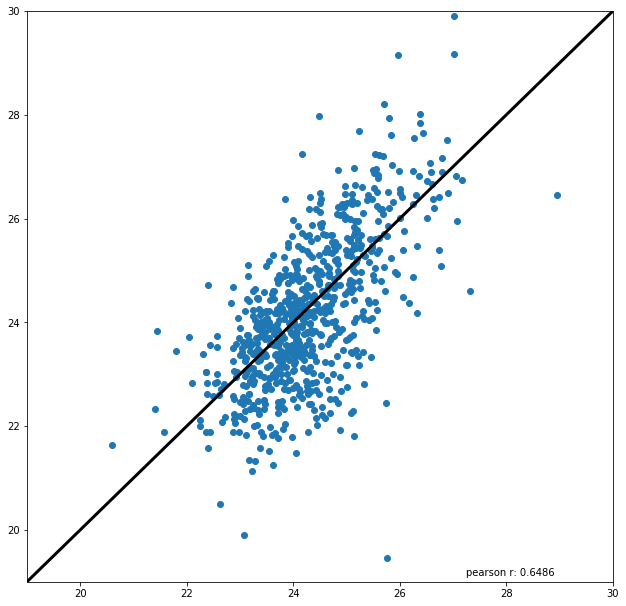

In [111]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(predicted,y_test)
ax.set_xlim(19,30)
ax.set_ylim(19,30)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(y_test.squeeze(),predicted.squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)
# ax.plot([0,1],[0,1], transform=ax.transAxes)